#### Time Series Analysis of using ARIMA AND SARIMAX

**ARIMA and Seasonal ARIMA**

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

#### Import Libraries

In [24]:
import numpy as np
import pandas as pd 
from datetime import datetime as dt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import math
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6

import warnings
warnings.filterwarnings('ignore')


### Load Dataset 

In [25]:
data=pd.read_csv("PerrinFreres-Monthly-Champagne-.csv")
#data.columns=["Month", "Sales"]
data.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [26]:
data.dtypes

Month     object
Sales    float64
dtype: object

In [27]:
data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [28]:
data.shape

(107, 2)

In [29]:
#drop null values
data.dropna(axis=0,inplace=True)

In [30]:
#converting to datetime format 
data["Month"]=pd.to_datetime(data["Month"])

In [31]:
data=data.set_index('Month')
data.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [32]:
data.isnull().sum()

Sales    0
dtype: int64

### Step 1. Visualize the time series

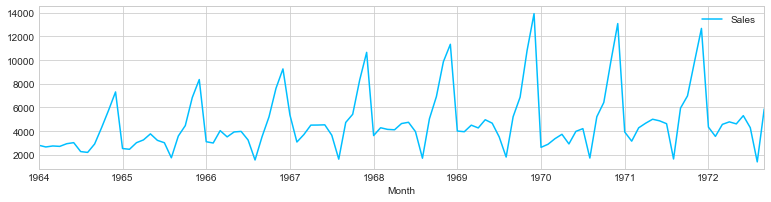

In [33]:
plt.style.use('seaborn-whitegrid')
data.plot(figsize=(13,3), color='deepskyblue')
plt.show()

<AxesSubplot:ylabel='Density'>

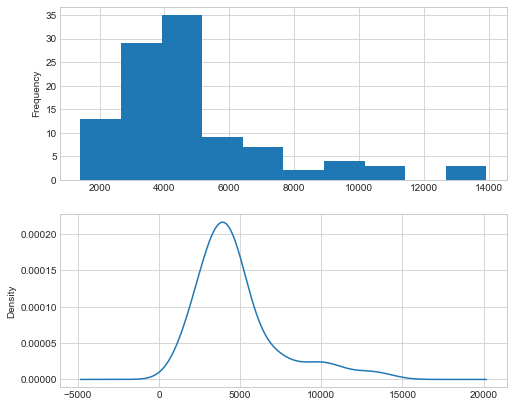

In [35]:
plt.figure(figsize=(8,7))
plt.subplot(211)
data.Sales.plot(kind='hist')
plt.subplot(212)
data.Sales.plot(kind='kde')

**Insights**
* The distribution is Gaussian (normal distribution).

<AxesSubplot:xlabel='Month', ylabel='Sales'>

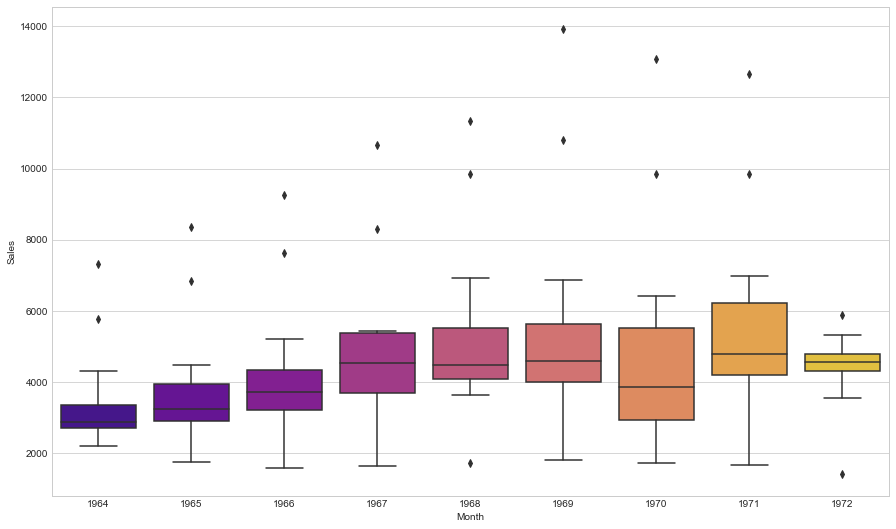

In [36]:
plt.figure(figsize=(15,9))
sns.boxplot(data.Sales.index.year, data.Sales, palette='plasma')

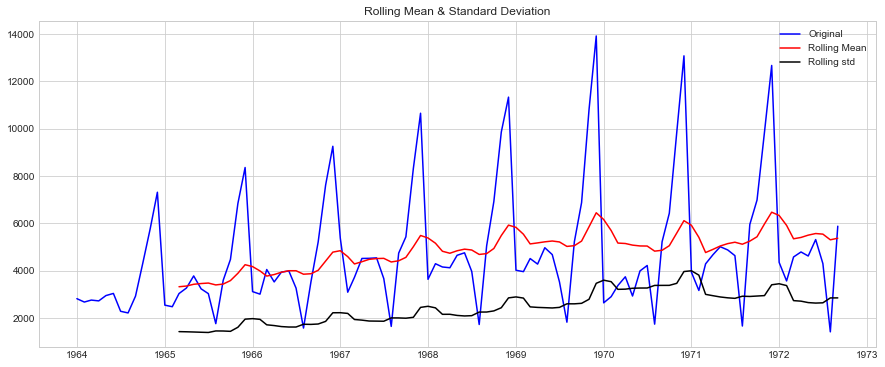

In [37]:
#Determine Rolling Statistics
rolmean=data.rolling(window=15).mean()
rolstd=data.rolling(window=15).std()

#plot Rolling Statistics
orig=plt.plot(data, color='blue', label='Original')
mean=plt.plot(rolmean, color='red', label='Rolling Mean')
mean=plt.plot(rolstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Insight**
* We observe that the moving(rolling) mean and moving std dev are not constant with respect to time (both are showing increasing trends). Ideal case moving avg., moving std dev must be constant.
* The time series is not stationary

### Step 2.  Augumented Dickey-fuller test

- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).

    * Null Hypothesis (H0) that the time series is not stationary and 
    * Alternate hypothesis (H1) that the time series is stationary. 

- The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the 'Test Statistic' is less than the 'Critical Value', we can reject the null hypothesis and say that the series is stationary.

In [39]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(data.Sales, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


- critical value= 5% i.e 0.05
- P value 0.36
- We accept the null hypothesis that the time series is not stationary at p value of 0.36.

In [40]:
# stationarity check function
# H0 - It is non stationary
# H1 - It is stationary (Alternative Hypothesis)
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#### there are multiple ways to make time series stationary

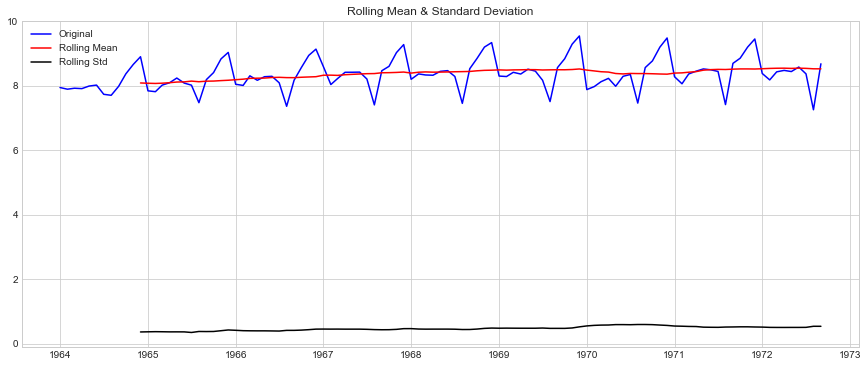

Results of Dickey-Fuller Test:
Test Statistic                 -2.255119
p-value                         0.186852
#Lags Used                     13.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


In [41]:
#1.Log transformation
ts_log=np.log(data)
test_stationarity(ts_log)

- P value > 0.05
- not making series stationary

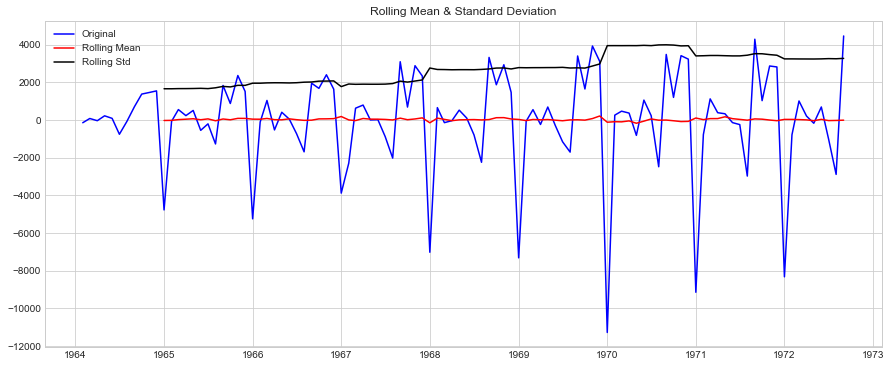

Results of Dickey-Fuller Test:
Test Statistic                -7.189896e+00
p-value                        2.519620e-10
#Lags Used                     1.100000e+01
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


In [42]:
#diffrencing
ts_diff=data-data.shift(1)
ts_diff.dropna(inplace=True) # drop null value
test_stationarity(ts_diff)

- now p less than 0.05,  but moving std is Not constant hence, null hypothesis is Accepted. therefore The series is Not stationary

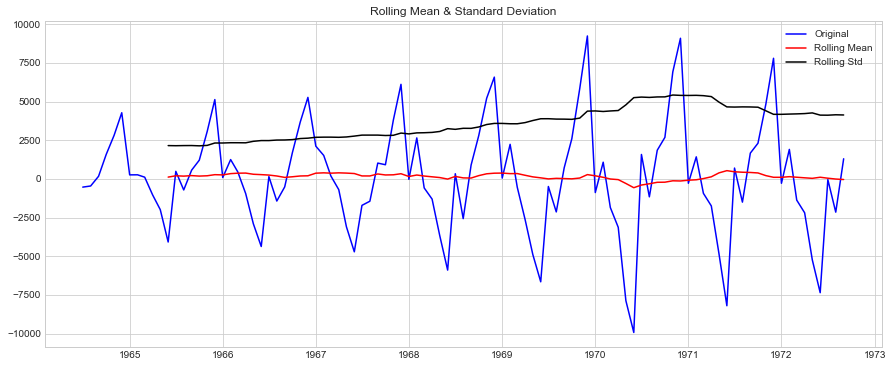

Results of Dickey-Fuller Test:
Test Statistic                -7.278598e+00
p-value                        1.521221e-10
#Lags Used                     6.000000e+00
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


In [49]:
ts_sea_diff=data['Sales']-data['Sales'].shift(6)
ts_sea_diff.dropna(inplace=True)
test_stationarity(ts_sea_diff)

* The series is Not stationary

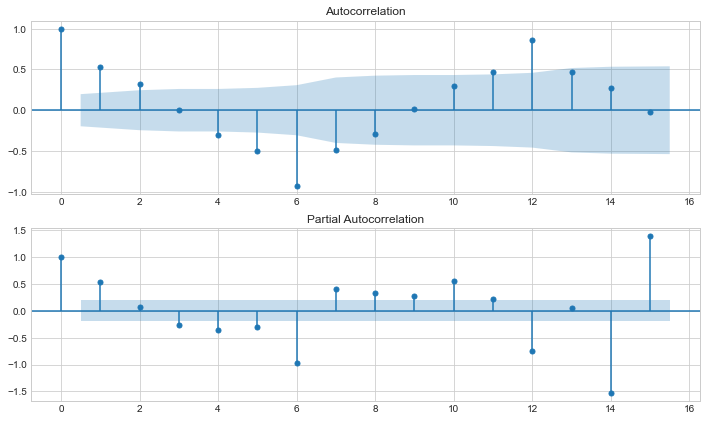

In [53]:
#ACF, PACF, p,d,q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize = (12,7))
plt.subplot(211)
plot_acf(ts_sea_diff, ax=plt.gca(),lags=15)
plt.subplot(212)
plot_pacf(ts_sea_diff, ax=plt.gca(),lags=15)
plt.show()

* The ACF curve crosses the upper confidence value when the lag value is between 0 and 1. Thus, optimal value of q in the ARIMA model must be 0 or 1
* The PACF curve drops to 0 between lag values 1. Thus, optimal value of p in the ARIMA model is 1.
* p=1, d=1, q=0 or 1

### Step 3. ARIMA Model

In [63]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [64]:
model=ARIMA(data['Sales'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Mon, 20 Mar 2023   AIC                           1910.251
Time:                        17:28:43   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7844     12.405      1.837      0.066      -1.529      47.098
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Month'>

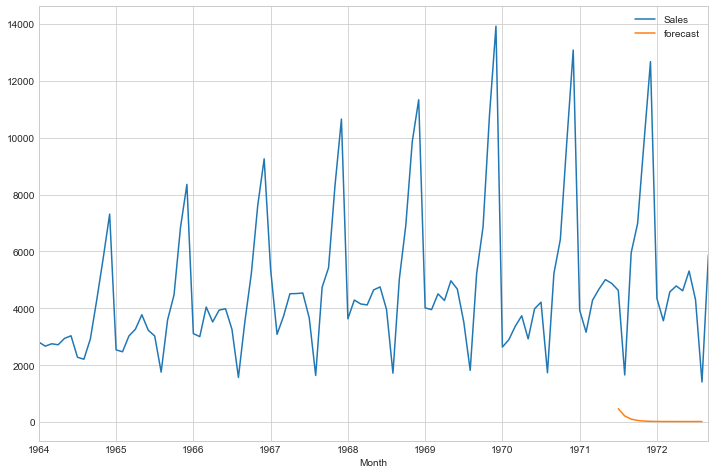

In [74]:
data['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
data[['Sales','forecast']].plot(figsize=(12,8))

**Note:** 

- ARIMA model not work well on Seasonal Dataset 
- SARIMAX(seasonal ARIMA) works well on seasonal dataset


#### SARIMAX Model

<AxesSubplot:xlabel='Month'>

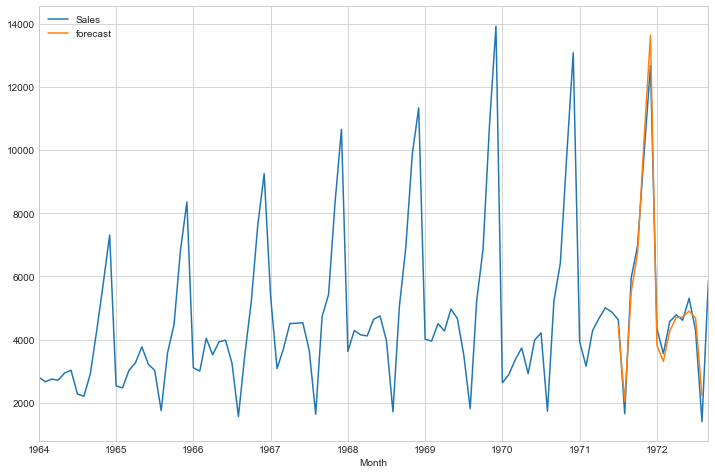

In [83]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
data['forecast']=results.predict(start=90,end=103,dynamic=True)
data[['Sales','forecast']].plot(figsize=(12,8))

In [84]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_datest_df.tail()

,Sales,forecast
1974-04-01,NaN,NaN
1974-05-01,NaN,NaN
1974-06-01,NaN,NaN
1974-07-01,NaN,NaN
1974-08-01,NaN,NaN


In [85]:
future_df=pd.concat([data,future_datest_df])

<AxesSubplot:>

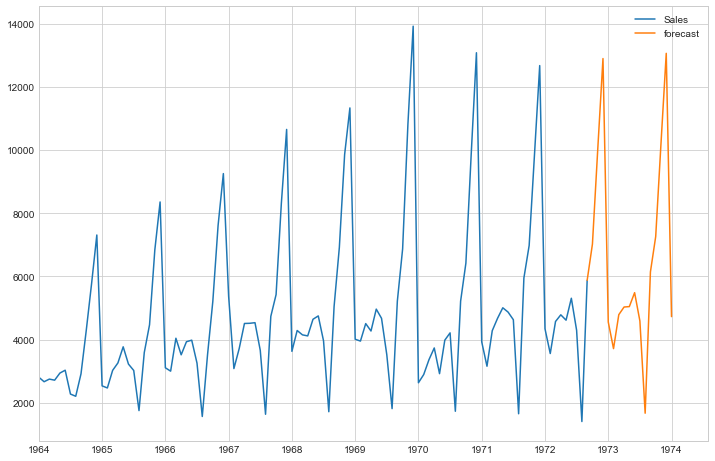

In [86]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 

### End